In [2]:
#Version
from qiskit import *
qiskit.__qiskit_version__

#Noise and Measurement Error Mitigation
#In this episode of Coding with Qiskit, we learned about noise, and saw how it affects quantum computation on real devices by introducing errors.

#To learn more about measurement error mitigation, check out the section in our open-source Qiskit textbook on this topic.

{'qiskit-terra': '0.12.0',
 'qiskit-aer': '0.4.1',
 'qiskit-ignis': '0.2.0',
 'qiskit-ibmq-provider': '0.5.0',
 'qiskit-aqua': '0.6.4',
 'qiskit': '0.16.1'}

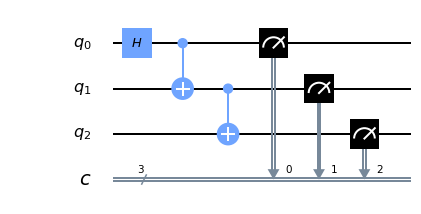

In [3]:
#Building a simple quantum circuit
nqubits = 3
circuit = QuantumCircuit(nqubits, nqubits)
circuit.h(0)
circuit.cx(0,1)
circuit.cx(1,2)
circuit.measure([0,1,2], [0,1,2])
circuit.draw(output='mpl')

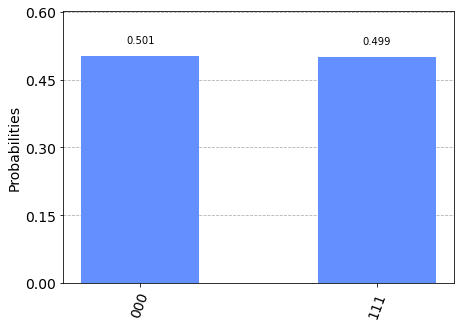

In [4]:
#Simulating the quantum circuit
simulator = Aer.get_backend('qasm_simulator')
sim_result = execute(circuit, backend=simulator, shots=1024).result()

from qiskit.visualization import plot_histogram
plot_histogram(sim_result.get_counts(circuit))

In [5]:
#Running the quantum circuit on a real quantum computer
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmqx2')
job = execute(circuit, backend=device, shots=1024)
#print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


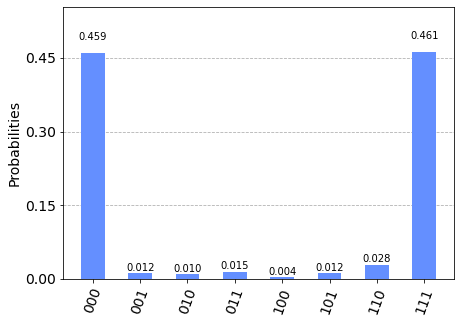

In [6]:
device_result = job.result()
plot_histogram(device_result.get_counts(circuit))

8


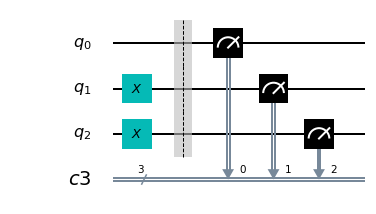

In [18]:
#Calibrating measurement errors using Qiskit Ignis
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

cal_circuits, state_labels = complete_meas_cal(qr=circuit.qregs[0], 
                                               circlabel='measurement_calibration')
print(len(cal_circuits))

#So ignis has given us a series of 8 calibration circuits to run - 
#we can check what the errors are in each of these circuits
#Why 8 circuits? - So that we can prepare each of the 8 states (000, 001, ..., 111) possible with 3 qubits
cal_circuits[6].draw(output='mpl')

In [19]:
#Now we create the calibration job on the device
cal_job = execute(cal_circuits,
             backend=device,
             shots=8192,
             optimization_level=0 #so that circuits are not changed from here to the real device
                 )
#print(cal_job.job_id())
job_monitor(cal_job)
cal_results = cal_job.result()

Job Status: job has successfully run


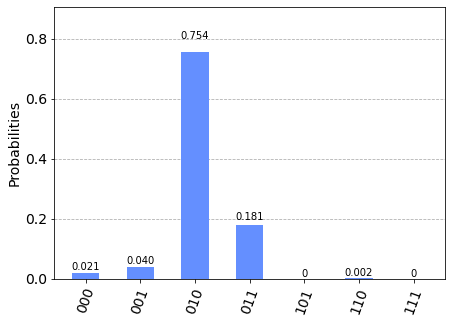

In [20]:
#Let us plot the histogram of one of the circuits, and 
#see whether we are getting the state with errors or not
plot_histogram(cal_results.get_counts(cal_circuits[2]))

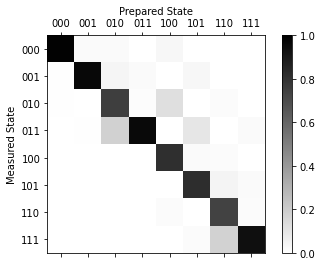

In [21]:
#Now that we have an error profile we can create a fitter that will account for these errors
#Creating the Measurement Fitter Object in Ignis
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
#This plot tells us that most of the results are correct but there are few errors (faint grey cells) as well
#Although these are small, they will matter in the computation if not addressed
meas_fitter.plot_calibration()

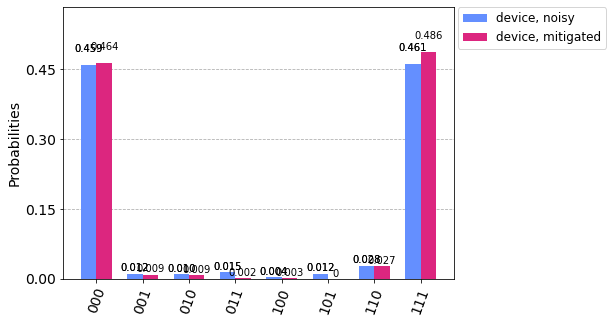

In [22]:
#Now we will create a filter - to filter out the errors
meas_filter = meas_fitter.filter
#We now apply the filter on the device results - to create the Mitigated measurement
mitigated_result = meas_filter.apply(device_result)
device_counts = device_result.get_counts(circuit) #original counts ran on the device
mitigated_counts = mitigated_result.get_counts(circuit) #mitigated counts
plot_histogram([device_counts, mitigated_counts], 
               legend=['device, noisy', 'device, mitigated'])

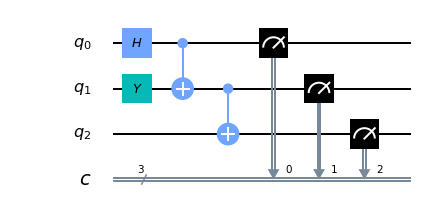

In [23]:
#We can reuse the calbration circuits and filters on another circuit using same # of qubits
#Running error mitigation on a second circuit
circuit2 = QuantumCircuit(3,3)
circuit2.y(1)
circuit2.h(0)
circuit2.cx(0,1)
circuit2.cx(1,2)
circuit2.measure([0,1,2], [0,1,2])
circuit2.draw(output='mpl')

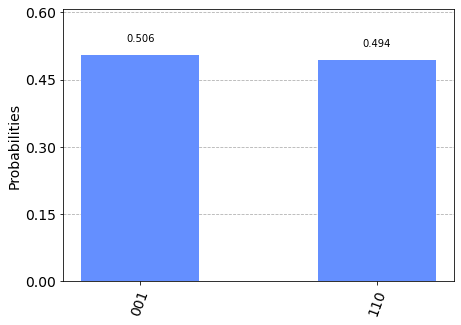

In [27]:
#How the circuit should behave in an ideal QC
plot_histogram(
    execute(circuit2, backend=simulator, shots=1024).result().get_counts(circuit2))

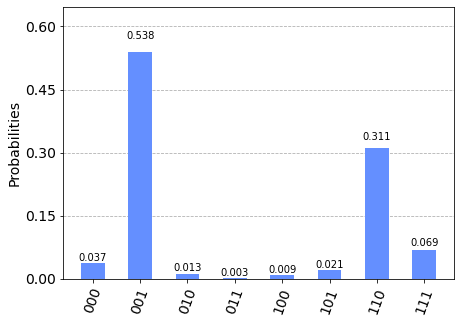

In [28]:
#We run the circuit in the real IBMQ device and plot the results
device_counts_2 = execute(circuit2, backend=device, shots=1024).result().get_counts(circuit2)
plot_histogram(device_counts_2)

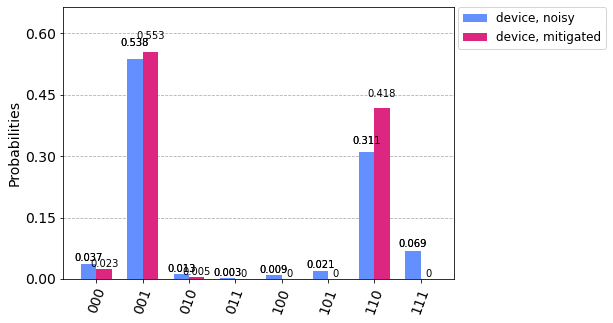

In [29]:
#We apply the previous filter based on the calibration circuits on these device counts
#And check how the results have improved
mitigated_counts_2 = meas_filter.apply(device_counts_2)
plot_histogram([device_counts_2, mitigated_counts_2], legend=['device, noisy','device, mitigated'])

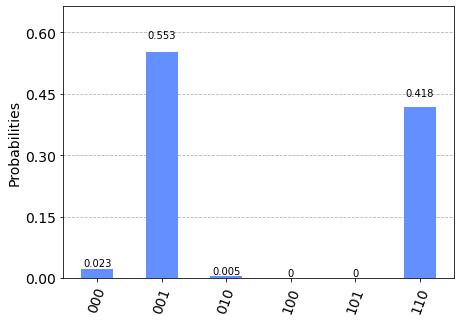

In [30]:
#If we plot just the mitigated counts, it should look much cleaner
plot_histogram(mitigated_counts_2)